In [1]:
import torch
import torchvision
from torchvision.transforms import v2

import matplotlib.pyplot as plt

In [2]:
device = "cuda" 

In [3]:
from pathlib import Path
import requests
from zipfile import ZipFile

data_path = Path("data/pizza_steak_sushi_v2")

if data_path.is_dir():
    print("Dataset sudah ada")
else:
    with open("data/pizza_steak_sushi_v2.zip","wb") as f:
        print("Downloading dataset...")
        res = requests.get(
            "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip"
        )
        f.write(res.content)
    with ZipFile("data/pizza_steak_sushi_v2.zip","r") as zipFile:
        print("Extracting dataset...")
        zipFile.extractall(data_path)

Dataset sudah ada


In [4]:
train_path = data_path / "train"
test_path = data_path / "test"

In [5]:
import os

for dirname,subdir,files in os.walk(data_path):
    print(f"In {dirname} there are {len(subdir)} folders and {len(files)} images")

In data\pizza_steak_sushi_v2 there are 2 folders and 0 images
In data\pizza_steak_sushi_v2\test there are 3 folders and 0 images
In data\pizza_steak_sushi_v2\test\pizza there are 0 folders and 46 images
In data\pizza_steak_sushi_v2\test\steak there are 0 folders and 58 images
In data\pizza_steak_sushi_v2\test\sushi there are 0 folders and 46 images
In data\pizza_steak_sushi_v2\train there are 3 folders and 0 images
In data\pizza_steak_sushi_v2\train\pizza there are 0 folders and 154 images
In data\pizza_steak_sushi_v2\train\steak there are 0 folders and 146 images
In data\pizza_steak_sushi_v2\train\sushi there are 0 folders and 150 images


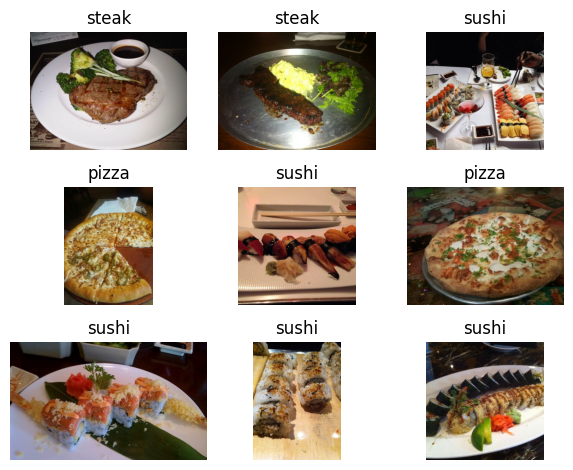

In [6]:
import random
from PIL import Image

all_images_path = list(Path.glob(data_path,"*/*/*.jpg"))


random_images_path = random.sample(all_images_path, k=9)


for i, image in enumerate(random_images_path):
    with Image.open(image) as img:
        plt.subplot(3,3,i+1)
        plt.imshow(img)
        plt.title(image.parent.stem)
        plt.axis(False)
        plt.tight_layout()

In [7]:
train_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(64,64)),
    v2.TrivialAugmentWide(num_magnitude_bins=31),
    v2.ToDtype(torch.float32,scale=True)
])

test_transform = v2.Compose(
    [v2.ToImage(), v2.Resize(size=(64, 64)), v2.ToDtype(torch.float32, scale=True)]
)

In [8]:
from torchvision.datasets import ImageFolder

train_data = ImageFolder(root=train_path, transform=train_transform)
test_data = ImageFolder(root=test_path, transform=test_transform)

len(train_data),len(test_data)

(450, 150)

In [9]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [24]:
from torch.utils.data import DataLoader

BATCH_SIZE = 150
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS)
test_dataloader = DataLoader(
    dataset=test_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
)

len(train_dataloader),len(test_dataloader)

(3, 1)

In [25]:
from torch import nn
class TinyVGG(nn.Module):
    def __init__(self, input_shape:int,hidden_units:int,output_shape:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
                stride=1,
            ),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units * 2, 3, 1, 1),
            nn.Conv2d(hidden_units * 2, hidden_units * 2, 3, 1, 1),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(hidden_units * 2, hidden_units, 3, 1, 1),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.MaxPool2d(kernel_size=2),
        )

        self.classfier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 8 * 8,hidden_units * 2),
            nn.ReLU(),
            nn.Linear(hidden_units * 2,hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units,output_shape)
        )

    def forward(self,x):
        # x = self.conv_block_1(x)
        # x = self.conv_block_2(x)
        # x = self.conv_block_3(x)
        # print(x.shape)
        return self.classfier(self.conv_block_3(self.conv_block_2(self.conv_block_1(x))))

In [26]:
model = TinyVGG(input_shape=3,hidden_units=32,output_shape=len(class_names)).to(device)

model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classfier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_featu

In [27]:
from torchinfo import summary

summary(model,input_size=(32,3,64,64),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 32, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 32, 64, 64]          896
│    └─Conv2d: 2-2                       [32, 32, 64, 64]          9,248
│    └─MaxPool2d: 2-3                    [32, 32, 32, 32]          --
├─Sequential: 1-2                        [32, 64, 16, 16]          --
│    └─Conv2d: 2-4                       [32, 64, 32, 32]          18,496
│    └─Conv2d: 2-5                       [32, 64, 32, 32]          36,928
│    └─MaxPool2d: 2-6                    [32, 64, 16, 16]          --
├─Sequential: 1-3                        [32, 32, 8, 8]            --
│    └─Conv2d: 2-7                       [32, 32, 16, 16]          18,464
│    └─Conv2d: 2-8                       [32, 32, 16, 16]          9,248
│    └─MaxPool2d: 2-9                    [32, 32, 8, 8]           

In [28]:
img,label = next(iter(train_dataloader))

label[0]

tensor(2)

In [29]:
img[0].shape,img[0].unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [30]:
img[0].dtype,label[0].dtype

(torch.float32, torch.int64)

In [31]:
model.eval()

with torch.inference_mode():
    y_logits = model(img[0].unsqueeze(0).to(device))
    print(y_logits)

tensor([[-0.0163,  0.0177,  0.0504]], device='cuda:0')


In [32]:
from torchmetrics.classification import Accuracy

acc_metrics = Accuracy(task="multiclass",num_classes=len(class_names)).to(device)

In [33]:
def train_step(data_loader:torch.utils.data.DataLoader,model:nn.Module,loss_fn:nn.Module,optimizer:torch.optim.Optimizer,device=device):
    model.train()

    train_loss = 0
    acc_metrics.reset()

    for X,y in data_loader:
        X,y = X.to(device),y.to(device)
        y_logits = model(X)
        y_preds = torch.argmax(y_logits,dim=1)

        loss = loss_fn(y_logits,y)
        train_loss += loss
        acc_metrics.update(y_preds,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    total_loss = train_loss / len(data_loader)
    train_acc = acc_metrics.compute()

    return total_loss, train_acc

In [34]:
def test_step(data_loader:torch.utils.data.DataLoader,model:nn.Module,loss_fn:nn.Module,device=device):
    model.eval()

    test_loss = 0
    acc_metrics.reset()
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device),y.to(device)
            y_logits = model(X)
            y_preds = torch.argmax(y_logits,dim=1)

            loss = loss_fn(y_logits,y)
            test_loss += loss
            acc_metrics.update(y_preds,y)

    total_loss = test_loss / len(data_loader)
    test_acc = acc_metrics.compute()
    return total_loss, test_acc

In [35]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

In [36]:
EPOCHS = 20

for epoch in range(EPOCHS):
    print(f"\nEpoch: {epoch}")
    train_loss,train_acc = train_step(train_dataloader,model,loss_fn,optimizer,device)
    test_loss, test_acc = test_step(
        train_dataloader, model, loss_fn, device
    )
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
    print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")


Epoch: 0
Train loss: 1.0997 | Train acc: 0.3111
Test loss: 1.0948 | Test acc: 0.3467

Epoch: 1
Train loss: 1.0906 | Train acc: 0.3578
Test loss: 1.0690 | Test acc: 0.3600

Epoch: 2
Train loss: 1.0610 | Train acc: 0.3667
Test loss: 1.0468 | Test acc: 0.4511

Epoch: 3
Train loss: 1.0381 | Train acc: 0.4644
Test loss: 1.0264 | Test acc: 0.4644

Epoch: 4
Train loss: 1.0039 | Train acc: 0.5289
Test loss: 1.0303 | Test acc: 0.4956

Epoch: 5
Train loss: 0.9983 | Train acc: 0.5222
Test loss: 1.0319 | Test acc: 0.4867

Epoch: 6
Train loss: 1.0050 | Train acc: 0.4933
Test loss: 0.9849 | Test acc: 0.4956

Epoch: 7
Train loss: 0.9928 | Train acc: 0.4867
Test loss: 0.9789 | Test acc: 0.5378

Epoch: 8
Train loss: 0.9543 | Train acc: 0.5400
Test loss: 0.9604 | Test acc: 0.5556

Epoch: 9
Train loss: 0.9352 | Train acc: 0.5600
Test loss: 0.9258 | Test acc: 0.5956

Epoch: 10
Train loss: 0.9355 | Train acc: 0.5356
Test loss: 0.9302 | Test acc: 0.5800

Epoch: 11
Train loss: 0.9113 | Train acc: 0.5867
Tes

In [ ]:
def predict_class(path:str):
    custom_image = torchvision.io.decode_image(path)
    custom_image_transformed = test_transform(custom_image)
    model.eval()
    with torch.inference_mode():
        y_logit = model(custom_image_transformed.unsqueeze(0).to(device))
        y_prob = torch.softmax(y_logit,dim=1)
        values,indices = y_prob.max(dim=1)
        y_pred = torch.argmax(y_prob,dim=1)

        plt.title(f"Class: {class_names[y_pred[0]]} | Prob: {values.item():.4f}")
        plt.imshow(custom_image.permute(1,2,0))
        plt.axis(False)

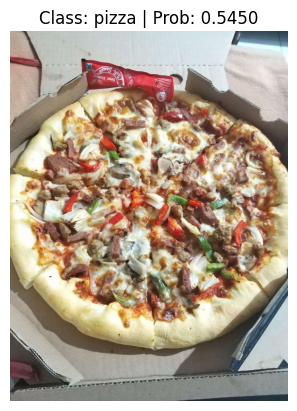

In [62]:
predict_class("data/kocakjpeg.jpeg")